# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist

In [3]:
numbers = mnist.load_data()[0][0]

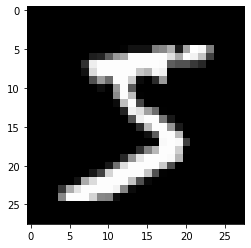

In [4]:
img = numbers[0]
plt.imshow(img, cmap="gray");

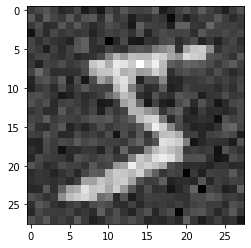

In [5]:
noisy = img + np.random.normal(scale=32, size=img.shape)
plt.imshow(noisy, cmap="gray");

# Paramètres

In [6]:
T2D = lambda x: x
T3D_ht = lambda x: x
T3D_ht_inv = lambda x: x
T3D_wie = lambda x: x
T3D_wie_inv = lambda x: x

N = 7
step = 2

threshold_t2d_ht = 32
threshold_dist_set = 15
threshold_t3d_ht = 32

sigma_ht = 1
sigma_wie = 1

# Fonctions

In [7]:
def generate_block(img, x, N=N):
    
    ret = np.zeros((N,N))

    x_max = min(x[0]+N, img.shape[0])
    y_max = min(x[1]+N, img.shape[1])

    ret[:x_max-x[0], :y_max-x[1]] = img[x[0]:x_max,x[1]:y_max]
    
    return ret

In [8]:
def dist(img1, img2, transfo_2D, threshold=None, N=N):

    x_max = min(img1.shape[0], img2.shape[0])
    y_max = min(img1.shape[1], img2.shape[1])
    
    T1 = transfo_2D(img1[:x_max, :y_max]).copy()
    T2 = transfo_2D(img2[:x_max, :y_max]).copy()
    
    if not threshold == None:
        T1[T1 < threshold] = 0
        T2[T2 < threshold] = 0

    return np.linalg.norm(T1 - T2)**2 / N**2

In [9]:
def create_set(xR, img, dist_func, T2D=T2D, threshold_dist=threshold_t2d_ht, thresh_dist_set=threshold_dist_set, nmax=None, N=N):

    xs = []
    dists = []

    block_ref = generate_block(img, xR)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            
            x = np.array([i, j])
            block = generate_block(img, x, N)
            
            dist = dist_func(block_ref, block, T2D, threshold=threshold_dist)
            
            if dist < thresh_dist_set:
                xs.append(x)
                dists.append(dist)
                
    set_xR = []
    
    if nmax == None:
        nmax = len(dists)
    
    for i in np.argsort(dists)[:nmax]:
        set_xR.append(xs[i])
        
    return set_xR

In [10]:
def stack(ens, img):
    
    ret = [generate_block(img, x) for x in ens]
    ret = np.stack(ret, axis=2)
    
    return ret

In [11]:
def transform_3D_ht(Z, w, threshold=threshold_t3d_ht, T3D=T3D_ht, T3D_inv=T3D_ht_inv):
    
    # For symmetry with transform_3D_wie
    w = None
    
    T = T3D(Z).copy()
    T[T < threshold] = 0
    
    return T3D_inv(T)

In [12]:
def generate_weights_ht(xRs, noisy, nmax_set=None, sigma=sigma_ht):
    
    weights = []
    sets = []
    
    for xR in xRs:
        
        S = create_set(xR, noisy, dist, nmax=nmax_set)
        Z = stack(S, noisy)
        sets.append(S)
        
        Y_hat = transform_3D_ht(Z, None)
        nz = np.count_nonzero(Y_hat)
        
        if nz == 0:
            weights.append(1)
        else:
            weights.append(1/(sigma**2 * nz))
            
    return weights, sets

In [13]:
def aggregation(xRs, img, weights, sets, transform_3D, N=N):
    
    height, width = img.shape
    
    num = np.zeros_like(img)
    den = np.zeros_like(img)
    
    for w, xR, S in zip(weights, xRs, sets):
        
        Y_hat = transform_3D(stack(S, img), w)
        
        #print(xR, len(S))
        
        for i in range(xR[0], min(xR[0]+N, height)):
            for j in range(xR[1], min(xR[1]+N, width)):
                
                num[i,j] += Y_hat[i-xR[0],j-xR[1],:].sum() * w
                
                for x in S:
                    if (i >= x[0] and i < x[0]+N) and (j >= x[1] and j < x[1]+N):
                        den[i,j] += w
    
    return num, den

In [14]:
def recreate_basic(xRs, noisy, nmax_set=None):
    
    weights, sets = generate_weights_ht(xRs, noisy, nmax_set=nmax_set)
    
    num, den = aggregation(xRs, noisy, weights, sets, transform_3D_ht)
    
    den[den==0] = 1
    y = num/den
    
    y = y.clip(max=y.mean()*2)
    y = y / np.max(y) * np.median(noisy)
    
    return y

In [15]:
def generate_w_wie(xRs, basic, noisy, nmax_set=None, T3D=T3D_wie, sigma=sigma_wie):
    
    Ws = []
    sets = []
    
    for xR in xRs:
        
        S = create_set(xR, basic, dist, threshold_dist=None, nmax=nmax_set)
        Y = stack(S, basic)
        sets.append(S)
        
        T = T3D(Y)**2
        W = T**2 / (T**2 + sigma**2)
        
        Ws.append(W)
            
    return Ws, sets

In [16]:
def transform_3D_wie(Z, W, T3D=T3D_wie, T3D_inv=T3D_wie_inv):
    
    collaborative_filtering = np.multiply(W, T3D(Z))
    
    return T3D_inv(collaborative_filtering)

In [17]:
def recreate_final(xRs, basic, noisy, nmax_set=None, sigma=sigma_wie):
    
    Ws, sets = generate_w_wie(xRs, basic, noisy, nmax_set=None, sigma=sigma)
    weights = [1 / (np.linalg.norm(W)**2 * sigma**2) for W in Ws]
    
    num, den = aggregation(xRs, noisy, weights, sets, transform_3D_wie)
    
    den[den==0] = 1
    y = num/den
    
    y = y.clip(max=y.mean()*2)
    y = y / np.max(y) * np.median(noisy)
    
    return y

In [18]:
def algo(xRs, noisy, nmax_set=None):
    
    basic = recreate_basic(xRs, noisy, nmax_set)
    final = recreate_final(xRs, basic, noisy, nmax_set)
    
    return final

# Tests

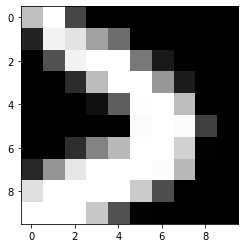

In [19]:
xR = np.array([12, 12])
block = generate_block(img, xR, 10)
plt.imshow(block, cmap="gray");

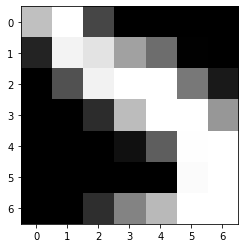

In [20]:
xR = np.array([12, 12])
block = generate_block(img, xR)
plt.imshow(block, cmap="gray");

22229.79591836734


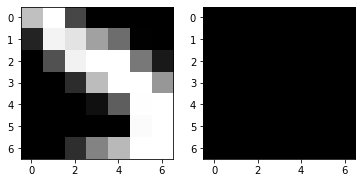

In [21]:
xR = np.array([12, 12])
x = np.array([24, 26])

block_ref = generate_block(img, xR)
block = generate_block(img, x)

print(dist(block_ref, block, T2D))

plt.subplot(1, 2, 1)
plt.imshow(block_ref, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(block, cmap="gray");

27733.38781358353


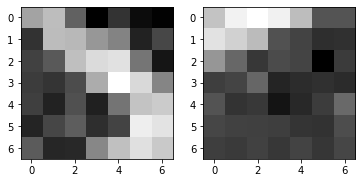

In [22]:
xR = np.array([12, 12])
x = np.array([19, 15])

block_ref = generate_block(noisy, xR)
block = generate_block(noisy, x)

print(dist(block_ref, block, T2D))

plt.subplot(1, 2, 1)
plt.imshow(block_ref, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(block, cmap="gray");

3


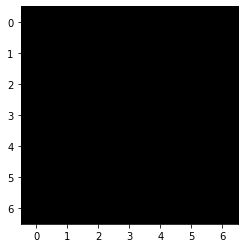

In [23]:
xR = np.array([24, 24])
S = create_set(xR, noisy, dist, threshold_dist=64, thresh_dist_set=100, nmax=3)

print(len(S))

block_ref = generate_block(img, xR)
plt.imshow(block_ref, cmap="gray");

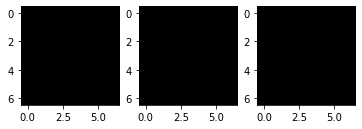

In [24]:
for i, x in enumerate(S):
    block = generate_block(img, x)
    plt.subplot(1, len(S), i+1)
    plt.imshow(block, cmap="gray")
plt.plot();

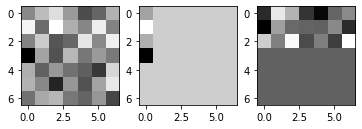

In [25]:
for i, x in enumerate(S):
    block = generate_block(noisy, x)
    plt.subplot(1, len(S), i+1)
    plt.imshow(block, cmap="gray")
plt.plot();

In [26]:
Z = stack(S, noisy)
print(Z.shape)

(7, 7, 3)


In [27]:
Y_hat = transform_3D_ht(Z, 32)
print(Y_hat.shape)

(7, 7, 3)


In [28]:
xR = np.array([12, 12])
generate_weights_ht([xR], noisy)

([0.030303030303030304], [[array([12, 12])]])

In [29]:
xR = np.array([12, 12])
new_image = recreate_basic([xR], noisy)

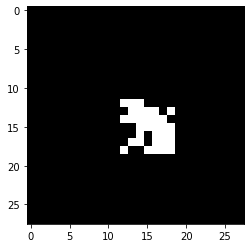

In [30]:
plt.imshow(new_image, cmap="gray");

In [31]:
xRs = [np.array([i, j]) for i in range(0, img.shape[0], step) for j in range(0, img.shape[1], step)]

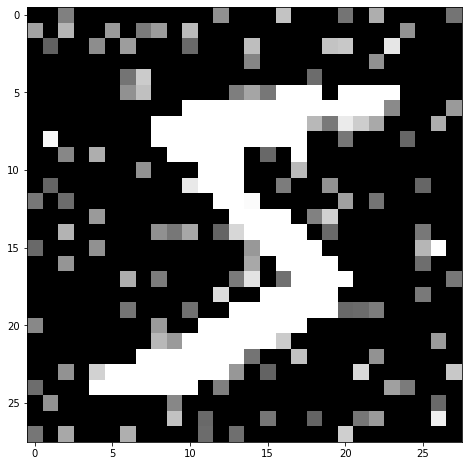

In [32]:
new_image = recreate_basic(xRs, noisy)
plt.figure(figsize=(15,8))
plt.imshow(new_image, cmap="gray");

41.657788976614704


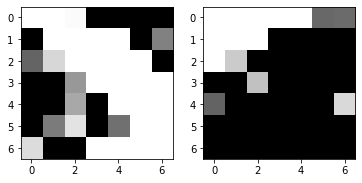

In [33]:
xR = np.array([12, 12])
x = np.array([19, 15])

block_ref = generate_block(new_image, xR)
block = generate_block(new_image, x)

print(dist(block_ref, block, lambda x: x))

plt.subplot(1, 2, 1)
plt.imshow(block_ref, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(block, cmap="gray");

In [34]:
xR = np.array([12, 12])
generate_w_wie([xR], new_image, noisy, nmax_set=10)

([array([[[0.99985514, 0.99985514],
          [0.99985514, 0.99985514],
          [0.99984466, 0.99985514],
          [0.        , 0.        ],
          [0.        , 0.        ],
          [0.        , 0.9974083 ],
          [0.        , 0.        ]],
  
         [[0.        , 0.        ],
          [0.99985514, 0.99985514],
          [0.99985514, 0.99985514],
          [0.99985514, 0.99984466],
          [0.99985514, 0.        ],
          [0.        , 0.        ],
          [0.99778445, 0.        ]],
  
         [[0.99401893, 0.        ],
          [0.99971031, 0.        ],
          [0.99985514, 0.99985514],
          [0.99985514, 0.99985514],
          [0.99985514, 0.99985514],
          [0.99985514, 0.99985514],
          [0.        , 0.        ]],
  
         [[0.        , 0.        ],
          [0.        , 0.99401893],
          [0.99884474, 0.99971031],
          [0.99985514, 0.99985514],
          [0.99985514, 0.99985514],
          [0.99985514, 0.99985514],
          [0.999

In [35]:
xR = np.array([12, 12])
basic_image = recreate_basic([xR], noisy)
final_image = recreate_final([xR], basic_image, noisy)

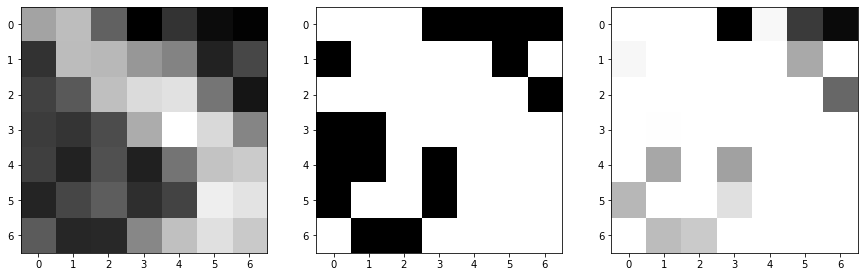

In [36]:
plt.figure(figsize=(15,15))

plt.subplot(1,3,1)
plt.imshow(generate_block(noisy, xR), cmap="gray")

plt.subplot(1,3,2)
plt.imshow(generate_block(basic_image, xR), cmap="gray")

plt.subplot(1,3,3)
plt.imshow(generate_block(final_image, xR), cmap="gray")

plt.plot();

In [37]:
xRs = [np.array([i, j]) for i in range(0, img.shape[0], step) for j in range(0, img.shape[1], step)]

In [38]:
basic = recreate_basic(xRs, noisy)

In [39]:
final = recreate_final(xRs, basic, noisy)

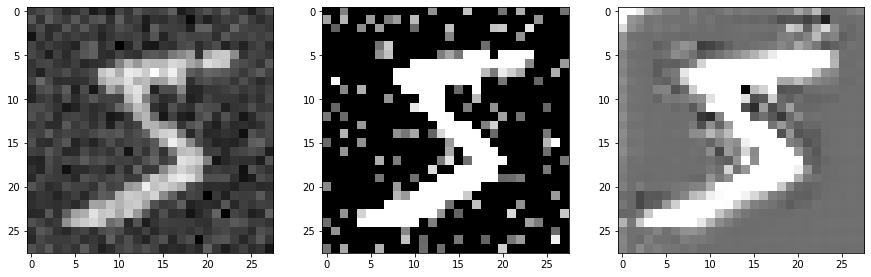

In [40]:
plt.figure(figsize=(15,15))

plt.subplot(1,3,1)
plt.imshow(noisy, cmap="gray")

plt.subplot(1,3,2)
plt.imshow(basic, cmap="gray")

plt.subplot(1,3,3)
plt.imshow(final, cmap="gray")

plt.plot();

# Algo final

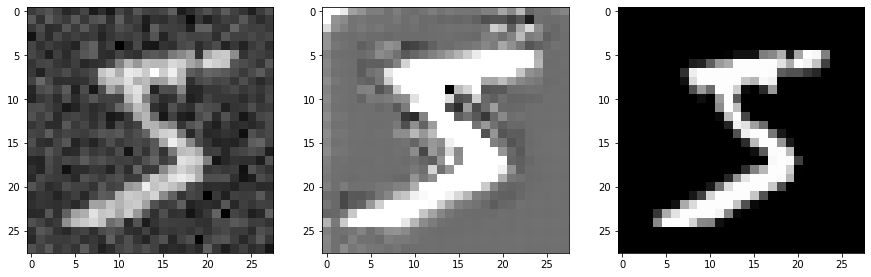

In [41]:
y = algo(xRs, noisy)

plt.figure(figsize=(15,15))

plt.subplot(1,3,1)
plt.imshow(noisy, cmap="gray")

plt.subplot(1,3,2)
plt.imshow(y, cmap="gray")

plt.subplot(1,3,3)
plt.imshow(img, cmap="gray")

plt.plot();